# Preprocessing


- Remove remaining non-numeric features
- Remove highly correlated features
- Check for for Homoscedasticity, skewness and outliers
- Model selection 

In [57]:
import pandas as pd
import numpy as np
import scipy.stats as sps
from scipy.special import boxcox, inv_boxcox
from scipy.stats import skew
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from pycaret.regression import *

In [23]:
# import HDB resale transaction records from 2015 to 2019 as training and validation dataset
trainval_df = pd.read_csv("../datasets/combined/combined_2015_2019_featured.csv")

# import HDB resale transaction records from 2020 (up to May) as test dataset
test_df = pd.read_csv("../datasets/combined/combined_2020_featured.csv")

### Consolidate Flat Models

There are 24 flat models in the datasets. Most buyers find them confusing, and it will be difficulat for them to select the flat model when they use my web application to predict prices. 

For that reaon I will reduce number of models from 20 to 6, retaining only dbss, terrace, maisonette, apartment, model_type_s1 and model_type_s2. They are one-hot-coded and "apartment" is represented by all zeros. 

Buyers only need to consider the flat types (4 room, 5 room, etc) and 4 models, as advised by HDB at this link
https://www.hdb.gov.sg/cs/infoweb/residential/buying-a-flat/new/types-of-flats

In [38]:
test_df.columns

Index(['sale_date', 'town', 'flat_type', 'storey_range', 'floor_area_sqm',
       'flat_model', 'lease_commence_date', 'remaining_lease', 'resale_price',
       'address', 'floor_range', 'bedok', 'bishan', 'bukit_batok',
       'bukit_merah', 'bukit_panjang', 'bukit_timah', 'central_area',
       'choa_chu_kang', 'clementi', 'geylang', 'hougang', 'jurong_east',
       'jurong_west', 'kallang_whampoa', 'marine_parade', 'pasir_ris',
       'punggol', 'queenstown', 'sembawang', 'sengkang', 'serangoon',
       'tampines', 'toa_payoh', 'woodlands', 'yishun', 'model_adjoined_flat',
       'model_apartment', 'model_dbss', 'model_improved',
       'model_improved_maisonette', 'model_maisonette', 'model_model_a',
       'model_model_a2', 'model_model_a_maisonette', 'model_multi_generation',
       'model_new_generation', 'model_premium_apartment',
       'model_premium_apartment_loft', 'model_premium_maisonette',
       'model_simplified', 'model_standard', 'model_terrace', 'model_type_s1',
   

In [24]:
# merge 4 maisonette columns into one and drop all othe columns for flat models

for i in trainval_df[trainval_df['model_improved_maisonette']==1].index:
    trainval_df.iloc[i,41]=1

for i in trainval_df[trainval_df['model_model_a_maisonette']==1].index:
    trainval_df.iloc[i,41]=1
    
for i in trainval_df[trainval_df['model_premium_maisonette']==1].index:
    trainval_df.iloc[i,41]=1
    
for i in test_df[test_df['model_improved_maisonette']==1].index:
    test_df.iloc[i,41]=1

for i in test_df[test_df['model_model_a_maisonette']==1].index:
    test_df.iloc[i,41]=1
    
for i in test_df[test_df['model_premium_maisonette']==1].index:
    test_df.iloc[i,41]=1

trainval_df.drop(columns=['model_adjoined_flat','model_apartment','model_improved','model_model_a',
                         'model_model_a2','model_multi_generation','model_new_generation', 
                          'model_premium_apartment','model_premium_apartment_loft', 
                         'model_simplified', 'model_standard', 
                         'model_improved_maisonette','model_model_a_maisonette','model_premium_maisonette'
                         ],inplace=True)


test_df.drop(columns=['model_adjoined_flat','model_apartment','model_improved','model_model_a',
                         'model_model_a2','model_multi_generation','model_new_generation', 
                          'model_premium_apartment','model_premium_apartment_loft', 
                         'model_simplified', 'model_standard', 
                         'model_improved_maisonette','model_model_a_maisonette','model_premium_maisonette'
                         ],inplace=True)

In [25]:
# drop non-numeric columns

trainval_df.drop(columns=['town','address','sale_date','flat_type','flat_model','storey_range'],inplace=True)
test_df.drop(columns=['town','address','sale_date','flat_type','flat_model','storey_range'],inplace=True)

# Drop redundant columns

# 1. lat and lng became redundant after distances from point of interest were added

# 2. Both 'lease commence date' and 'remaining lease' tell us the age of the flat, but the latter is more relevant 
# because it reflects the change in value based on when the flat is purchased. For example if a flat was built in 1990
# its 'lease commence date' remains the same regardless of whether it is sold in 2000 or 2010, but 'remaining lease'
# will decrease over that period


trainval_df.drop(columns=['lat','lng','lease_commence_date'],inplace=True)
test_df.drop(columns=['lat','lng','lease_commence_date'],inplace=True)

## Feature reduction - Remove towns

In [26]:
trainval_df.drop(columns=['bedok', 'bishan', 'bukit_batok',
       'bukit_merah', 'bukit_panjang', 'bukit_timah', 'central_area',
       'choa_chu_kang', 'clementi', 'geylang', 'hougang', 'jurong_east',
       'jurong_west', 'kallang_whampoa', 'marine_parade', 'pasir_ris',
       'punggol', 'queenstown', 'sembawang', 'sengkang', 'serangoon',
       'tampines', 'toa_payoh', 'woodlands', 'yishun', 'dist_attraction'],inplace=True)


test_df.drop(columns=['bedok', 'bishan', 'bukit_batok',
       'bukit_merah', 'bukit_panjang', 'bukit_timah', 'central_area',
       'choa_chu_kang', 'clementi', 'geylang', 'hougang', 'jurong_east',
       'jurong_west', 'kallang_whampoa', 'marine_parade', 'pasir_ris',
       'punggol', 'queenstown', 'sembawang', 'sengkang', 'serangoon',
       'tampines', 'toa_payoh', 'woodlands', 'yishun','dist_attraction'],inplace=True)

In [27]:
# remove any spaces
trainval_df.replace(' ','',regex=True,inplace=True)
test_df.replace(' ','',regex=True,inplace=True)

In [28]:
# check for nan
trainval_df.isna().values.any()

False

In [29]:
test_df.isna().values.any()

False

In [30]:
# check for duplicated rows
df = pd.DataFrame()
df['duplicate'] = trainval_df.duplicated()
df[df.duplicate==True]

,duplicate


In [31]:
# check duplicated rows
df = pd.DataFrame()
df['duplicate'] = test_df.duplicated()
df[df.duplicate==True]

,duplicate


### Check for Collinearity

In [32]:
# I wrote this function to loop through all features to check for pairwise correlation

def high_corr_features(df,pos_thres,neg_thres):
    
    # drop target variable
    df = df.drop(columns=['resale_price'])
        
    # get the pairwise correlation of oll features in the dataframes
    corr = df.corr()

    # loop through the dataframe to find the lowest and higher correlation numbers 
    # Correlation between the same feature will be Ones, so those will be skipped

    maxx=0
    minn=0
    for i in range(len(corr)):
        for j in range(len(corr)):
            if i != j:
                if corr.iloc[i,j]>0:
                    if corr.iloc[i,j]>maxx:
                        maxx=corr.iloc[i,j]
                        if maxx >= pos_thres:
                            print('Features that are highly positve correlated:',corr.index[i],corr.columns[j],maxx)
                else:
                    if corr.iloc[i,j]<minn:
                        minn=corr.iloc[i,j]
                        if minn <= neg_thres:
                            print('Features that are highly negative correlated:',corr.index[i],corr.columns[j],minn)


    print('Lowest negative correlation between features:',minn)
    print('Highest positive correlation between features:',maxx)

In [33]:
# Find features with correlation greater than 0.8 or less than -0.8
high_corr_features(trainval_df,0.8,-0.8)

Features that are highly positve correlated: cpi mth_income 0.8033530638302419
Features that are highly positve correlated: cpi condo_index 0.8325817903756152
Features that are highly negative correlated: gdp_growth condo_index -0.8740304765493228
Features that are highly positve correlated: sibor_3m mth_income 0.9119435809915178
Features that are highly negative correlated: sibor_3m hdb_index -0.9217577479217779
Features that are highly positve correlated: married mth_income 0.975389183268293
Features that are highly negative correlated: married hdb_index -0.9421162518560051
Features that are highly positve correlated: married total_residents 0.9854907613148901
Features that are highly negative correlated: mth_income hdb_index -0.9711252621439082
Features that are highly positve correlated: mth_income total_residents 0.9964384379732519
Lowest negative correlation between features: -0.9711252621439082
Highest positive correlation between features: 0.9964384379732519


In [34]:
# Drop columns with high correlation and those that have little influence on prediction outcome

trainval_df.drop(columns=['sibor_3m','total_residents','married','pte_index','condo_index',
                          'new_flat_offered', 'new_pte_home_offered','mth_income','hdb_index',
                          'dist_school','dist_library'],inplace=True)

test_df.drop(columns=['sibor_3m','total_residents','married','pte_index','condo_index',
                          'new_flat_offered', 'new_pte_home_offered','mth_income','hdb_index',
                     'dist_school','dist_library'],inplace=True)

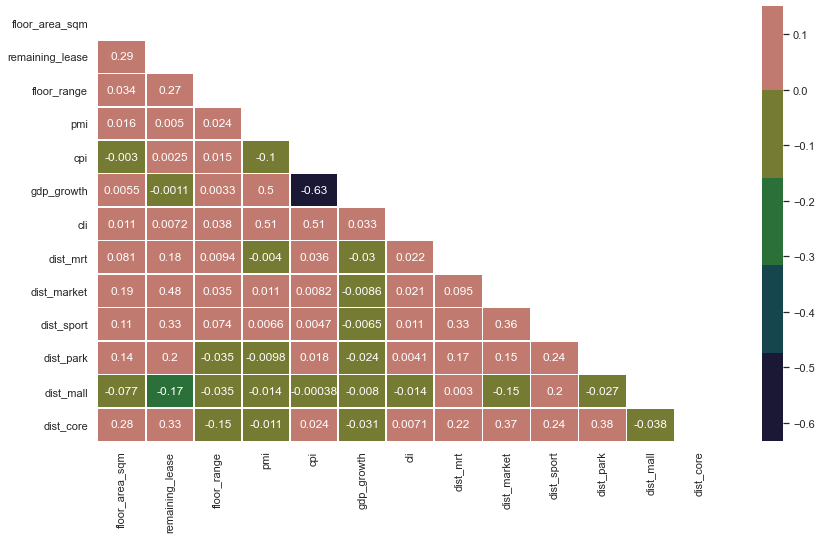

In [36]:
# Visualization of collinearity using Heatmap

sns.set(style="white")
        
corr = trainval_df[['floor_area_sqm', 'remaining_lease', 'floor_range', \
        'pmi', 'cpi', 'gdp_growth', 'cli', 'dist_mrt', \
        'dist_market', 'dist_sport', 'dist_park', 'dist_mall', \
        'dist_core']].corr()
fig,ax = plt.subplots(figsize=(14,8))

cmap = sns.color_palette("cubehelix", 8)


mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr,mask=mask,cbar=True,annot=True,linewidths=0.5,cmap=cmap,square=False,vmax=.15, center=0)

The figures in the heatmap look good - nothing below -0.8 or above 0.8. With the Collinearity issue resolved I will look into Multilinearity. Both of them are about correlation between predictors, but Collinearity is between 2 predictors, whereas Multicollinearity is about more than 2 predictors.


### Check for Multilinearity

- Use Variance Inflation Factor to check for mulitlinearity among predictors

I will only be checking non-categorical features, because Multicollinearity for Dummy variables can be ignored, according to [Professor Paul Allison.](https://statisticalhorizons.com/multicollinearity)

In [37]:
vif_cols = ['floor_area_sqm', 'remaining_lease', 'resale_price', 'floor_range',
        'pmi', 'cpf_rate', 'cpi', 'gdp_growth', 'cli',
        'dist_mrt', 'dist_market', 
        'dist_sport', 'dist_park', 'dist_mall']

df = trainval_df[vif_cols]

In [38]:
# Calculate VIF for selected features

vif = pd.DataFrame(
    (variance_inflation_factor(df.values, i) 
     for i in range(df.shape[1])), 
    index=df.columns, columns=['VIF_value']
     )

vif.sort_values(by=['VIF_value'],ascending=False).head(30)

,VIF_value
cpf_rate,67784.472386
cpi,3.223655
resale_price,3.136913
gdp_growth,2.653764
cli,2.573914
floor_area_sqm,2.409354
pmi,2.018024
remaining_lease,1.839468
dist_market,1.671270
dist_sport,1.485909


The result shows cpf_rate has ultra high VIF, so I will be dropping cpf_rate

In [39]:
trainval_df.drop(columns=['cpf_rate'],inplace=True)
test_df.drop(columns=['cpf_rate'],inplace=True)

### Check for Outliers with Cook's Distance

In [40]:
# First I will split each dataset into target and features

X = trainval_df.drop(columns=['resale_price'])
y = trainval_df['resale_price']
X_test = test_df.drop(columns=['resale_price'])
y_test = test_df['resale_price']

## Note: The codes below take hours to run

If you want to run, please uncomment all the codes below

In [18]:
from yellowbrick.regressor import CooksDistance

# Instantiate and fit the visualizer
# visualizer = CooksDistance()
# visualizer.fit(X, y)
# visualizer.show()

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [19]:
# outliers = pd.DataFrame({'index':visualizer.distance_.index,'distance':visualizer.distance_})
# outliers

In [20]:
# for i in range(len(outliers)):
#     if outliers.iloc[i,1]>0.005:
#         print(outliers.iloc[i,0],outliers.iloc[i,1])

In [21]:
# X[X.index==3116]['model_terrace']

In [22]:
# X[X.index==7905]['model_terrace']

In [23]:
# X[X.index==44056]['model_terrace']

In [24]:
# X[X.index==45910]['model_terrace']

In [25]:
# X[X.index==56639]['model_terrace']

All of them are terrace houses, which HDB has stopped building since the early 1970s because they of Singapore's land constraint and HDB's vision of providing affordable housing.

Due to rarity they fetch high prices even though they have low floor and low remaining lease.

It is not surprising that they were marked as potential outliers but I will not remove because these are not data entry or data collection error. I would keep them so that the model can learn about their existence.

### Handle skewness

Skewness is a measure of symmetry in a distribution. Many prediction algorithims require the variables to be symmetrical (or normally distributed). A perfectly normal distribution has skewness of zero, but in practise the following is the guidelines:
- Between -0.5 and 0.5 is considered Symmetrical
- Between -1 and -0.5 or between 0.5 and 1 is considered Moderately Skewed
- Below -1 or above 1 is considered Highly Skewed

I will use 0.7 as the threshold to determine whether to apply normalization

Normally it is necessary to normalize variables that are skewed, but according to Tianqi Chen (creator of XGBoost), it is not necessary to do so for XGBoost. (Source: [TQ Chen's answer on Github](https://github.com/dmlc/xgboost/issues/357) and [TQ Chen's article).](https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)

However, he did not mention target variable, so I will setup different models to compare the effect of normalization for independent and dependent variables. 

In [41]:
# check for data skewness (dummy variables are excluded)
trainval_df[['floor_area_sqm', 'remaining_lease', 'floor_range',
                 'pmi', 'cpi', 'gdp_growth','cli',  
                 'resale_price', 
                 'dist_mrt', 'dist_market','dist_sport', 'dist_park', 'dist_mall'
            ]].skew(axis = 0, skipna = True).sort_values(ascending=False)

floor_range        1.564996
dist_market        1.434065
resale_price       1.192974
dist_mrt           1.059301
dist_park          1.049563
dist_mall          0.990779
dist_sport         0.984625
pmi                0.912983
cpi                0.355781
floor_area_sqm     0.275802
cli                0.084624
remaining_lease    0.073329
gdp_growth        -0.228348
dtype: float64

In [47]:
# Train/test split based on normalized y
X_train, X_val, y_train, y_val = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_val_ss = ss.transform(X_val)
X_test_ss = ss.transform(X_test)

In [48]:
# normalize target variable
ylog_train = boxcox(y_train,-0.6)
ylog_val = boxcox(y_val,-0.6)
ylog_test = boxcox(y_test,-0.6)

In [49]:
# Make copies of datasets
Xlog_train = X_train.copy(deep=True)
Xlog_val = X_val.copy(deep=True)
Xlog_test = X_test.copy(deep=True)

# Select features to be considered for normalization (dummy variables are not included)
numeric_cols = pd.Index(['floor_area_sqm', 'remaining_lease', 'floor_range',
                 'pmi', 'cpi', 'gdp_growth','cli',
                  'dist_mrt', 'dist_market'])

skewed_cols = Xlog_train[numeric_cols].apply(lambda x: skew(x.dropna())) 
skewed_cols = skewed_cols[skewed_cols > 0.7]
skewed_cols = skewed_cols.index

# Between -0.5 and 0.5 are considered sysmterical
# Between -1 and -0.5 or between 0.5 and 1 are considered moderately skewed
# Below -1 or above 1 is considered highly skewed
# I decided to use 0.7 as the threshold to determine whether to apply normalization

for s in skewed_cols:
    Xlog_train[s] = boxcox(X_train[s],-0.6)
    Xlog_val[s] = boxcox(X_val[s],-0.6)
    Xlog_test[s] = boxcox(X_test[s],-0.6)

In [50]:
X_train.columns

Index(['floor_area_sqm', 'remaining_lease', 'floor_range', 'model_dbss',
       'model_maisonette', 'model_terrace', 'model_type_s1', 'model_type_s2',
       'type_2_room', 'type_3_room', 'type_4_room', 'type_5_room',
       'type_executive', 'type_multi_generation', 'cli', 'pmi', 'cpi',
       'gdp_growth', 'unemployed_rate', 'dist_mrt', 'dist_mall', 'dist_market',
       'dist_park', 'dist_sport', 'dist_core'],
      dtype='object')

### Comparing Log and Boxcox

Boxcox adjust the transformation according to the data rather than having a one-size-fix-all approach and so always provide better results than the simple log. Below are 2 examples to illustrate their differences. 

org skewness: 1.1929519051388626
skewness of y_train after log: 0.3669071051008628
skewness of y_train after boxcox : -0.10716185173286544
skewness of y_val after boxcox: -0.12164591534043204
skewness of y_test after boxcox: -0.36599718014328664


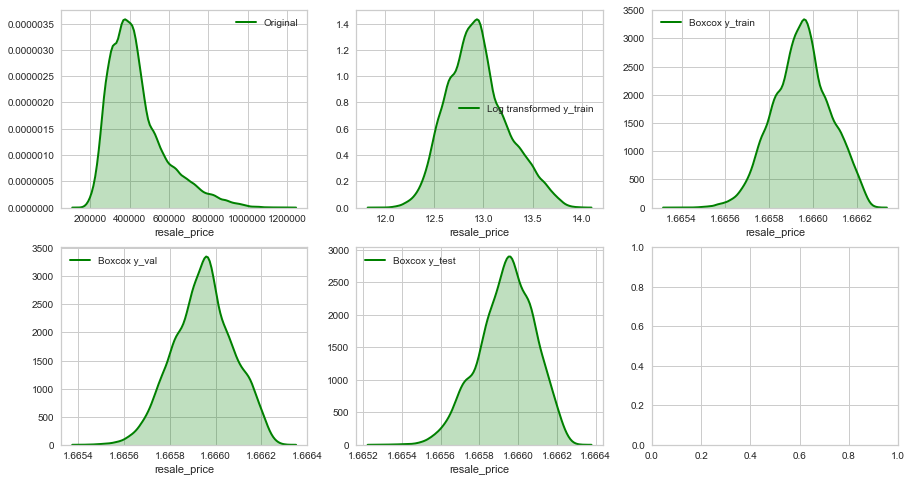

In [30]:
print('org skewness:',skew(trainval_df['resale_price']))
print('skewness of y_train after log:',skew(np.log(trainval_df['resale_price'])))
print('skewness of y_train after boxcox :',skew(ylog_train))
print('skewness of y_val after boxcox:',skew(ylog_val))
print('skewness of y_test after boxcox:',skew(ylog_test))

# Visualize the difference between before and after log transformation of target variable  
# creating axes to draw plots 
fig, ax = plt.subplots(2, 3) 
  
# plotting the original data(non-normal) and  
# fitted data (normal) 
sns.distplot(trainval_df['resale_price'], hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Original", color ="green", ax = ax[0,0]) 
  
sns.distplot(np.log(trainval_df['resale_price']), hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Log transformed y_train", color ="green", ax = ax[0,1])

sns.distplot(ylog_train, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Boxcox y_train", color ="green", ax = ax[0,2]) 


sns.distplot(ylog_val, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Boxcox y_val", color ="green", ax = ax[1,0]) 


sns.distplot(ylog_test, hist = False, kde = True, 
            kde_kws = {'shade': True, 'linewidth': 2},  
            label = "Boxcox y_test", color ="green", ax = ax[1,1]) 

   
# rescaling the subplots 
fig.set_figheight(8) 
fig.set_figwidth(15) 

## Baseline Linear Regression

- Ordinary Least Square Linear Regression as baseline
- Metrics used are RMSE (the lower the better) and R2 (the higher the better)

The objective of a regression model is to minimize the difference between predicted values and observed data values, and I used RMSE and R2 (R-squared) to measure the difference (aka error). The difference is R2 is a relative measure of fit, wheras RMSE is an absolute measure of fit. The advantage of RMSE is that it is in the same unit as as the target variable, which makes it easier for interpretation. For this reason I am using RMSE to measure the performance of my regression models.

In [52]:
# instantiate an instance of linear regression model and fit it with X_train and y_train values
reg = LinearRegression().fit(X_train, y_train)

# Calculate predictions for training and validation sets
pred_val = reg.predict(X_val)
pred_train = reg.predict(X_train)

# Get the scores for both metrics
rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
print("RMSE train: %.7f" % (rmse_train))
print("RMSE validation: %.7f" % (rmse_val))
print('R2 Score: %.7f' % reg.score(X_train,y_train))

RMSE train: 57110.4380386
RMSE validation: 56682.4173964
R2 Score: 0.8442501


In [53]:
# Perform cross validation for more reliable score
results = cross_val_score(reg, X_train, y_train, cv=KFold(n_splits=5))
print('CV Average R2 Score: %.7f' % results.mean())

CV Average R2 Score: 0.8440584


### Homoscedasticity check

I will plot Predictions vs. residuals to check for Homoscedasticity

Data are homoscedastic if the residuals have no clear relationship with predictions and has a normal distribution 

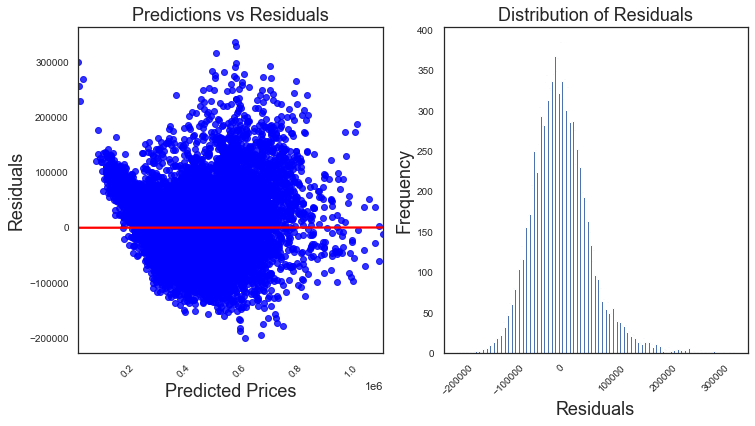

In [54]:
# specify the plot size
fig = plt.figure(figsize=(12, 6))

# Predictions vs Residuals
plt.subplot(1,2,1)
sns.regplot(pred_val, y_val-pred_val,ci=None, data=trainval_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.xlabel('Predicted Prices',fontsize=18)
plt.ylabel('Residuals',fontsize=18)
plt.xticks(fontsize=10,rotation=45)
plt.title('Predictions vs Residuals',fontsize=18)
plt.yticks(fontsize=10);

# Residual Distribution
plt.subplot(1,2,2)
plt.hist(y_val-pred_val,bins=200);
plt.xlabel('Residuals',fontsize=18)
plt.ylabel('Frequency',fontsize=18)
plt.xticks(fontsize=10,rotation=45)
plt.title('Distribution of Residuals',fontsize=18)
plt.yticks(fontsize=10);



The above plots show the residuals have no clear relationship with predictions and has a normal distribution, which means the data has homoscedasticity and meets the requirement of linear regression.

For linear regression it is important for normality of residuals, not the dependent variable. Many experts have weighed in on this subject.
https://www.researchgate.net/post/Is_linear_regression_valid_when_the_outcome_dependant_variable_not_normally_distributed

In [55]:
# save the final version of data before modeling
trainval_df.to_csv("../datasets/final/trainval.csv",index=False)
test_df.to_csv("../datasets/final/test.csv",index=False)

In [58]:
exp_reg101 = setup(data = trainval_df, target = 'resale_price', session_id=123)

 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(80897, 26)"
4,Missing Values,False
5,Numeric Features,13
6,Categorical Features,12
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [59]:
compare_models(whitelist=['ada','gbr','knn','lasso','lr','dt','rf','svm','xgboost'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Extreme Gradient Boosting,24225.5680,1156853225.3277,33979.9424,0.9449,0.0722,0.0551,2.1213
1,Random Forest,24489.3859,1255150336.2973,35401.1190,0.9401,0.0737,0.0552,3.9671
2,Gradient Boosting Regressor,31464.0878,1931329392.5213,43928.6677,0.9079,0.0918,0.0710,2.8600
3,Decision Tree,34070.6299,2489908054.1498,49875.3743,0.8812,0.1048,0.0770,0.1484
4,Lasso Regression,43319.5980,3282409674.6619,57261.9983,0.8436,0.1430,0.1028,0.8388
5,Linear Regression,43316.0337,3283047255.0277,57267.9454,0.8436,0.1429,0.1027,0.0189
6,AdaBoost Regressor,64055.0453,5680762817.4945,75340.7956,0.7290,0.1805,0.1655,1.6875
7,K Neighbors Regressor,65191.2434,8487477976.2419,92055.2397,0.5959,0.2007,0.1529,0.1666
8,Support Vector Machine,107474.9656,21947988686.4867,148057.2739,-0.0440,0.3098,0.2412,10.2419


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

### XGBoost emerges as the winner

Tensorfold Keras was not part of the comparison, so I will evaluate Keras manually in the next notebook

In [56]:
# Store variables for use in modeling

%store X_train
%store X_val
%store X_test
%store y_train
%store y_val
%store y_test

%store X_train_ss
%store X_val_ss
%store X_test_ss

%store ylog_train
%store ylog_val
%store ylog_test

%store Xlog_train
%store Xlog_val
%store Xlog_test

%store X
%store y

Stored 'X_train' (DataFrame)
Stored 'X_val' (DataFrame)
Stored 'X_test' (DataFrame)
Stored 'y_train' (Series)
Stored 'y_val' (Series)
Stored 'y_test' (Series)
Stored 'X_train_ss' (ndarray)
Stored 'X_val_ss' (ndarray)
Stored 'X_test_ss' (ndarray)
Stored 'ylog_train' (Series)
Stored 'ylog_val' (Series)
Stored 'ylog_test' (Series)
Stored 'Xlog_train' (DataFrame)
Stored 'Xlog_val' (DataFrame)
Stored 'Xlog_test' (DataFrame)
Stored 'X' (DataFrame)
Stored 'y' (Series)
